In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/normalizing-flows"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/normalizing-flows


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Reshape, Conv2D
from tensorflow.keras.datasets import mnist
from flows import Flow
from flows.affine import Planar, Radial
from layers import GatedConv2D, GatedConv2DTranspose, FlowLayer
tfd = tfp.distributions

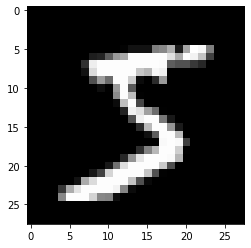

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255
plt.imshow(X_train[0], cmap='gray')

In [0]:
d = 64
n_layers = 8
flow = Flow(Planar())
for i in range(1, n_layers):
    flow(Planar())

In [0]:
def vae(wt, ht, flow, n_flows=1, hidden_units=64, z_size=64):
    from tensorflow.keras.callbacks import LambdaCallback
    p = flow.param_count(z_size)
    input_0 = Input((wt, ht, 1))
    def conv_downsample(x):
        g = GatedConv2D(hidden_units, 3, activation='linear')
        g_downsample = GatedConv2D(hidden_units, 3, strides=2)
        return g_downsample(g(x))
    def conv_upsample(x):
        g = GatedConv2DTranspose(hidden_units, 3, activation='linear')
        g_upsample = GatedConv2DTranspose(hidden_units, 3, strides=2)
        return g_upsample(g(x))
    h = conv_downsample(conv_downsample(input_0))
    z_mu = Dense(z_size, activation='linear')(Flatten()(h))
    z_log_sigma = Dense(z_size, activation='linear')(Flatten()(h))
    params = Dense(flow.param_count(z_size), activation='linear')(Flatten()(h))
    flow_forward = FlowLayer(flow, min_beta=1.0E-3)
    z_0, z_k, ldj, kld = flow_forward([z_mu, z_log_sigma, params])
    h_k = Dense(wt//4 * ht // 4, activation='linear')(z_k)
    h_k = Reshape((wt//4, ht//4, 1))(h_k)
    x_out = conv_upsample(conv_upsample(h_k))
    output_0 = Conv2D(1, 1, activation='linear', padding='same')(x_out)
    beta_update = LambdaCallback(on_epoch_begin=lambda i,_: flow_forward.set_beta(1.0E-3/tf.math.exp(-i)))
    model = Model(inputs=input_0, outputs=output_0)
    model.compile(loss='mse', optimizer='adam', callbacks=[beta_update])
    return model

In [6]:
x_train = np.expand_dims(X_train, axis=-1) #.reshape((-1, X_train.shape[1]*X_train.shape[2]))
model = vae(x_train.shape[1], x_train.shape[2], flow, n_flows=n_layers, z_size=d)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


ValueError: ignored

In [0]:
model.fit(x_train, x_train, epochs=3, batch_size=128)

Train on 60000 samples
Epoch 1/3
36736/60000 [=================>............] - ETA: 19s - loss: 0.0820

KeyboardInterrupt: ignored

In [0]:
x_test = np.expand_dims(X_test, axis=-1) #X_test.reshape((-1, X_test.shape[1]*X_test.shape[2]))
x_pred = model.predict(x_test)

In [0]:
from tensorflow.keras.metrics import mean_squared_error
tf.math.reduce_mean(mean_squared_error(x_test, x_pred))

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

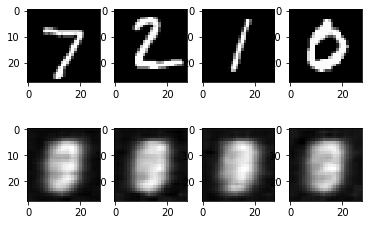

In [0]:
plt.subplot(2,4,1)
plt.imshow(X_test[0], cmap='gray')
plt.subplot(2,4,2)
plt.imshow(X_test[1], cmap='gray')
plt.subplot(2,4,3)
plt.imshow(X_test[2], cmap='gray')
plt.subplot(2,4,4)
plt.imshow(X_test[3], cmap='gray')
plt.subplot(2,4,5)
plt.imshow(x_pred[0].squeeze(), cmap='gray')
plt.subplot(2,4,6)
plt.imshow(x_pred[1].squeeze(), cmap='gray')
plt.subplot(2,4,7)
plt.imshow(x_pred[2].squeeze(), cmap='gray')
plt.subplot(2,4,8)
plt.imshow(x_pred[3].squeeze(), cmap='gray')
plt.show()